In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import time

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [3]:
from helper import plot_boundaries_keras, get_spiral_dataset, get_sphere_coordinates, get_cart_coordinates

In [4]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

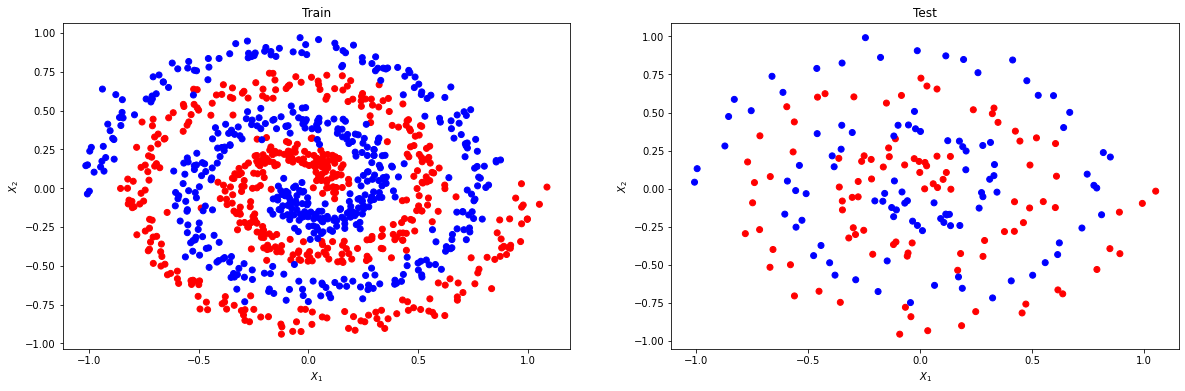

In [5]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)
ax1.set_xlabel('$X_1$')
ax1.set_ylabel('$X_2$')
ax1.set_title('Train')
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright)
ax2.set_xlabel('$X_1$')
ax2.set_ylabel('$X_2$')
ax2.set_title('Test')
plt.show()

##### 
##### 
##### 
#### Feature engineering: transforming X1 and X2

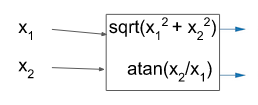

In [6]:
X_sphere = get_sphere_coordinates(X)
X_sphere_test = get_sphere_coordinates(X_test)

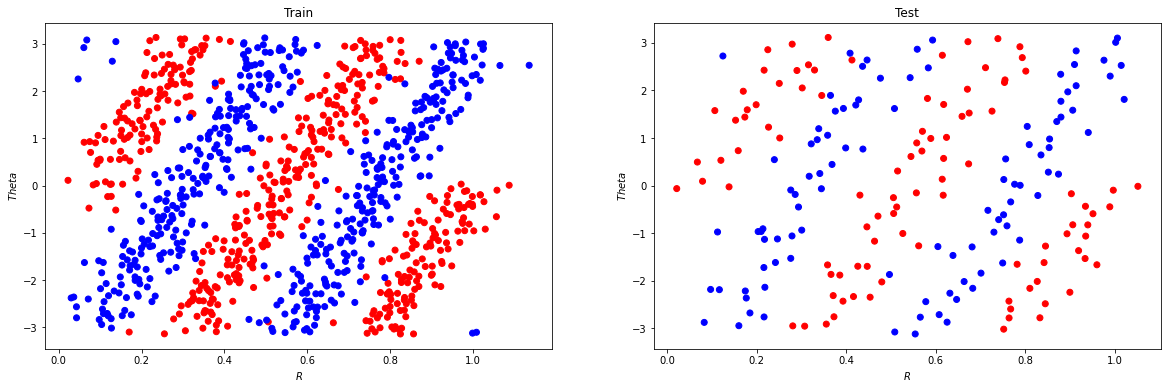

In [7]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.scatter(X_sphere[:,0], X_sphere[:,1], c=y, cmap=cm_bright)
ax1.set_xlabel('$R$')
ax1.set_ylabel('$Theta$')
ax1.set_title('Train')
ax2.scatter(X_sphere_test[:,0], X_sphere_test[:,1], c=y_test, cmap=cm_bright)
ax2.set_xlabel('$R$')
ax2.set_ylabel('$Theta$')
ax2.set_title('Test')
plt.show()

Text(0, 0.5, 'theta')

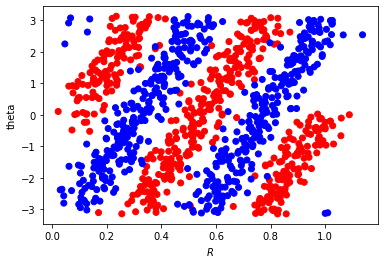

In [8]:
plt.scatter(X_sphere[:,0], X_sphere[:,1], c=y, cmap=cm_bright)
plt.xlabel('$R$')
plt.ylabel('theta')

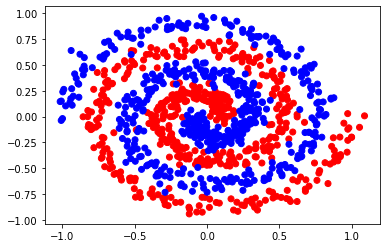

In [9]:
plt.scatter(X_sphere[:,0]*np.cos(X_sphere[:,1]), X_sphere[:,0]*np.sin(X_sphere[:,1]), c=y, cmap=cm_bright)

##### 
##### 
##### 
#### Simple model w/ feature engineering:

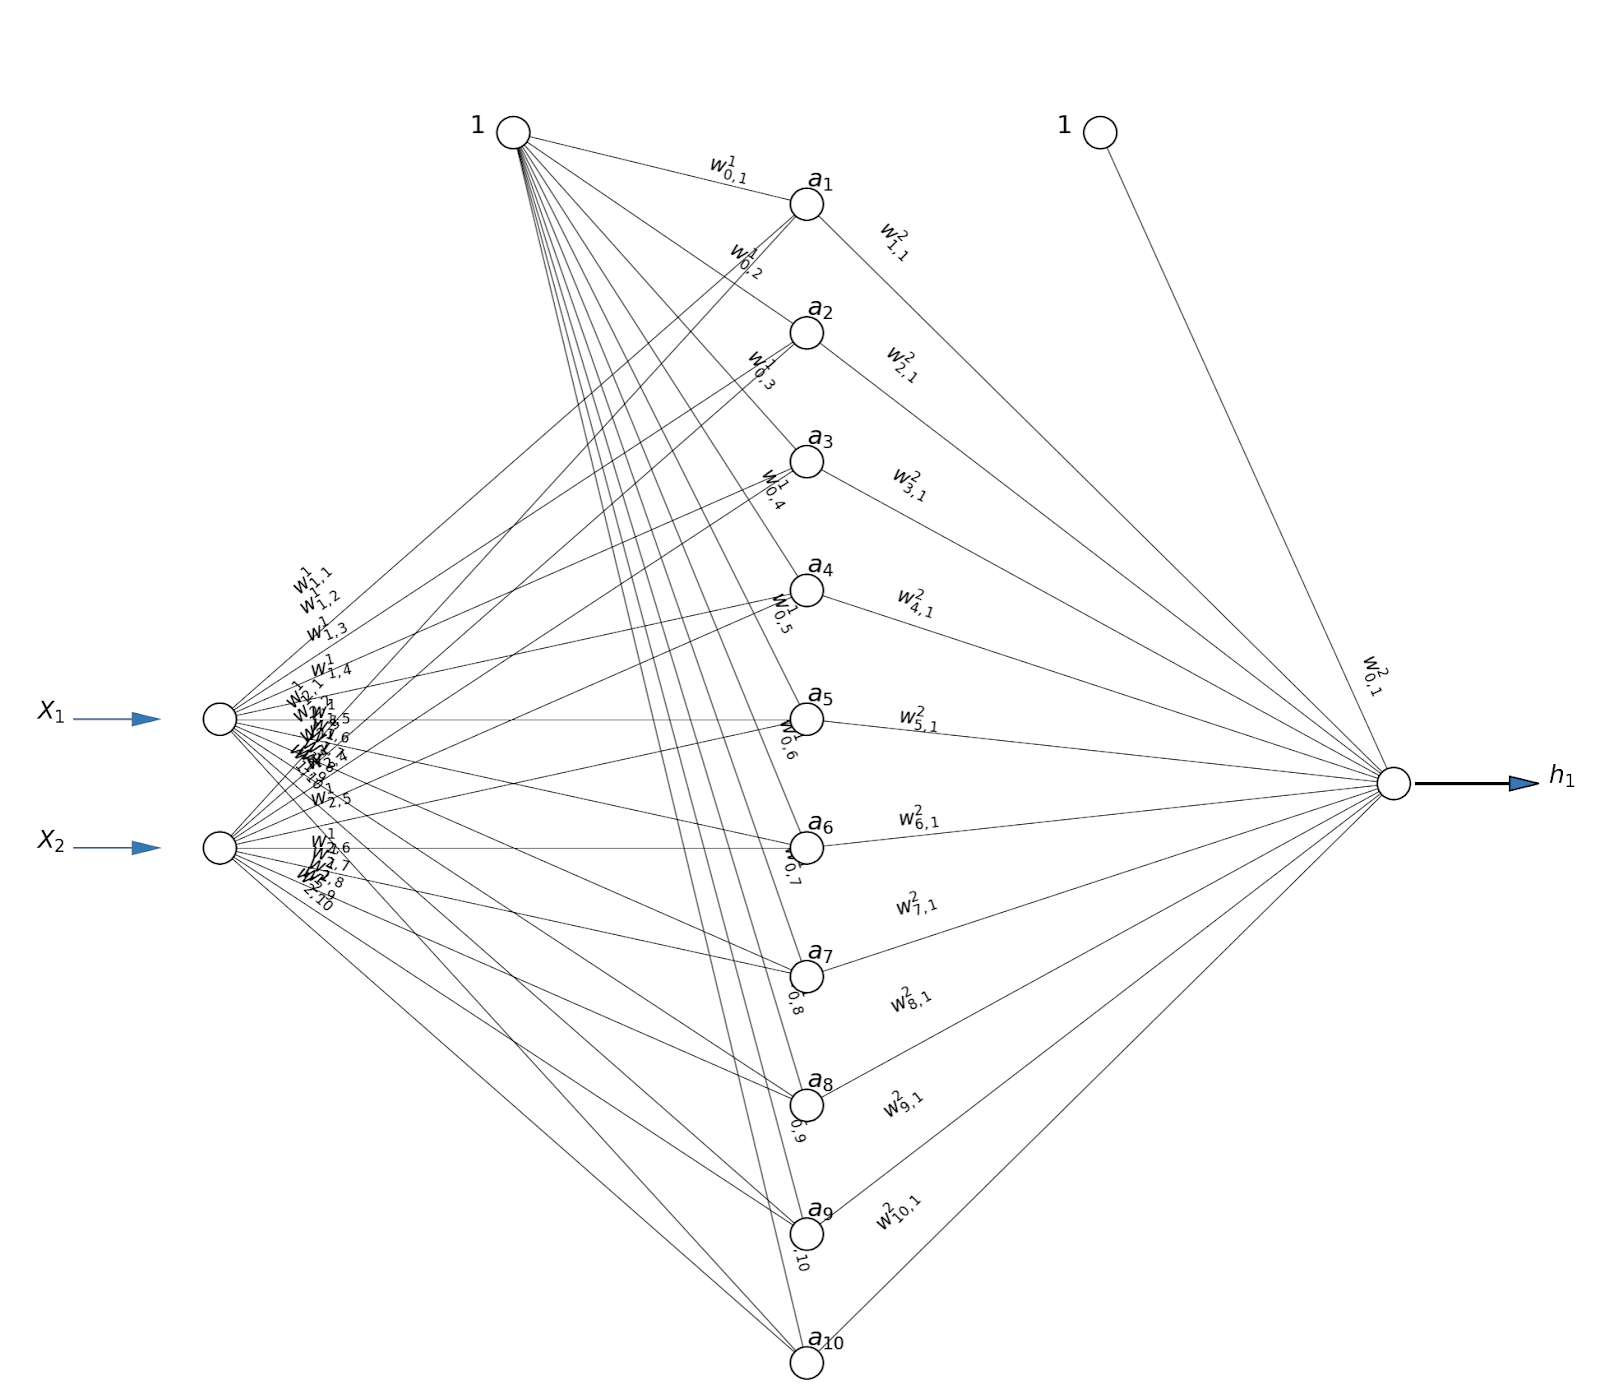

In [12]:
def get_simple_model(activation='sigmoid', input_dim=2, hidden_units=10, lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input') # Input layer (tensor)
    X = Dense(hidden_units, input_shape=(1,), activation=activation, name='hidden')(X_in) # Hidden layer 
    X1 = Dense(1, name='Categorical_out', activation='sigmoid')(X) # Output layer (tensor)
    model = Model(X_in, X1) # Import Model, specifying input tensor and output tensor  
    if compile_model:
        losses = {'Categorical_out': 'binary_crossentropy'} # We can choose more than one loss
        metrics = {'Categorical_out': 'accuracy'}
        model.compile(Adam(learning_rate=lr), loss=losses, metrics=metrics)
    return model

In [13]:
simple_model = get_simple_model(lr=0.25, hidden_units=10)
simple_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
Categorical_out (Dense)      (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [14]:
epochs = 1000
history = simple_model.fit(X_sphere, y, verbose=0, epochs=epochs, batch_size=64)

In [18]:
score_train = score_func_simple(X, y)
score_test = score_func_simple(X_test, y_test)
print(score_train, score_test)

0.968999981880188 0.9700000286102295


In [19]:
def predict_proba_simple(X):
    X_rad = get_sphere_coordinates(X)
    return simple_model.predict(X_rad)

def score_func_simple(X, y):
    X_rad = get_sphere_coordinates(X)
    return simple_model.evaluate(X_rad, y, verbose=0)[1]

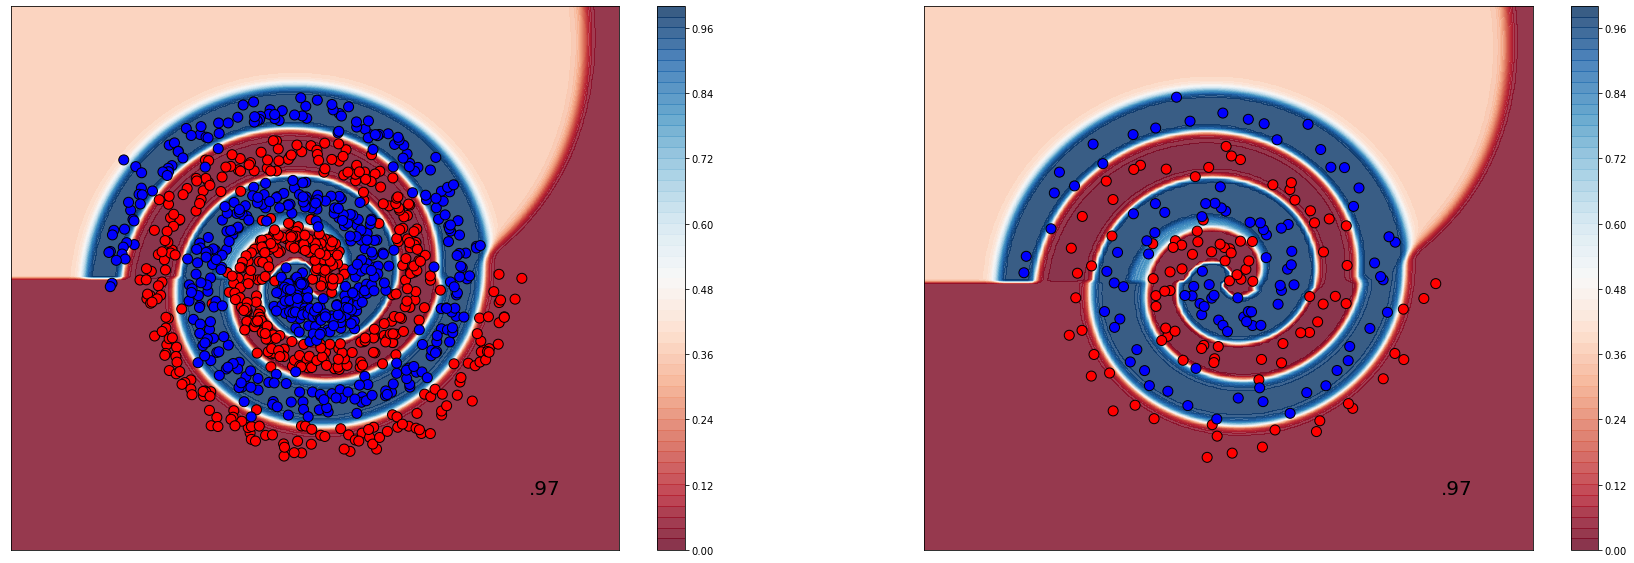

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X, y, score_train, probability_func=predict_proba_simple, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_test, probability_func=predict_proba_simple, ax=ax2)

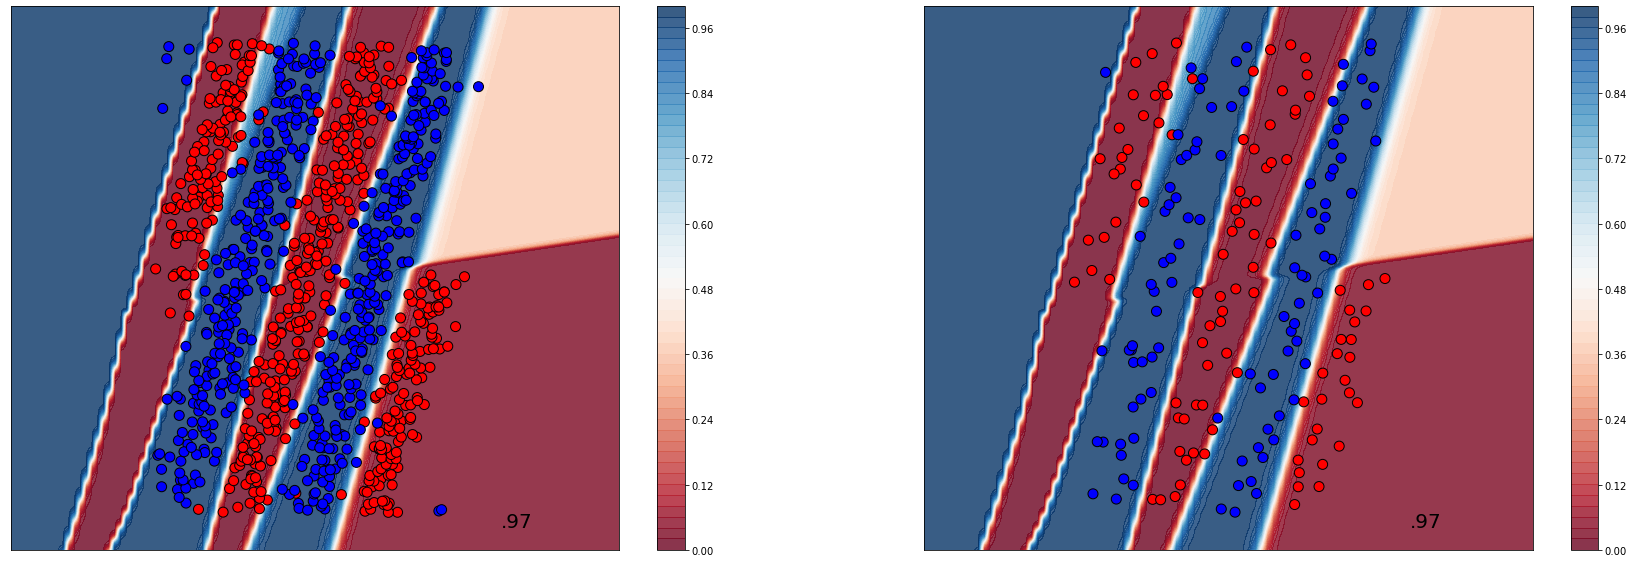

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X_sphere, y, score_train, probability_func=simple_model.predict, ax=ax1)
plot_boundaries_keras(X_sphere_test, y_test, score_test, probability_func=simple_model.predict, ax=ax2)

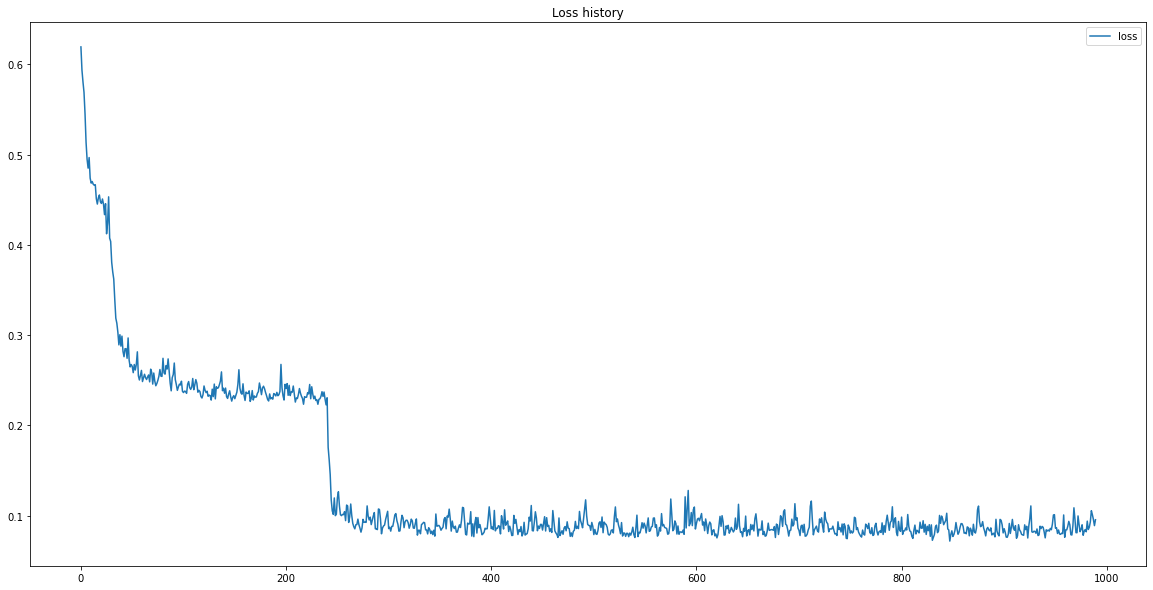

In [24]:
plt.figure(figsize=(20,10))
fr = 10
plt.plot(history.history['loss'][fr:], label='loss')
# plt.plot(model.history.history['Categorical_out_loss'][fr:], label='Categorical_out_mse')
# plt.plot(model.history.history['Linear_out_radius_loss'][fr:], label='Linear_out_radius_mse')
# plt.plot(model.history.history['Linear_out_theta_loss'][fr:], label='Linear_out_theta_mse')
plt.title('Loss history')
plt.legend()

##### 
##### 
##### 
#### Simple model <ins>without</ins> feature engineering:

In [72]:
def get_no_feat(activation='sigmoid', input_dim=2, hidden_units=[10], lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units[0], activation=activation, name=f'hidden_1')(X_in)
    for i, units in enumerate(hidden_units[1:]):
        X = Dense(units, activation=activation, name=f'hidden_{i+2}')(X)
    cat_out = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    
    model = Model(X_in, cat_out)
    if compile_model:
        model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [73]:
model_no_feat = get_no_feat(activation='sigmoid', hidden_units=[10], lr = 0.1)
model_no_feat.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 10)                30        
_________________________________________________________________
Categorical_out (Dense)      (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [75]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [76]:
epochs = 2000
model_no_feat.fit(X, y, verbose=0, epochs=epochs, batch_size=100, validation_data=(X_test, y_test))

##### Underfitting or overfitting?

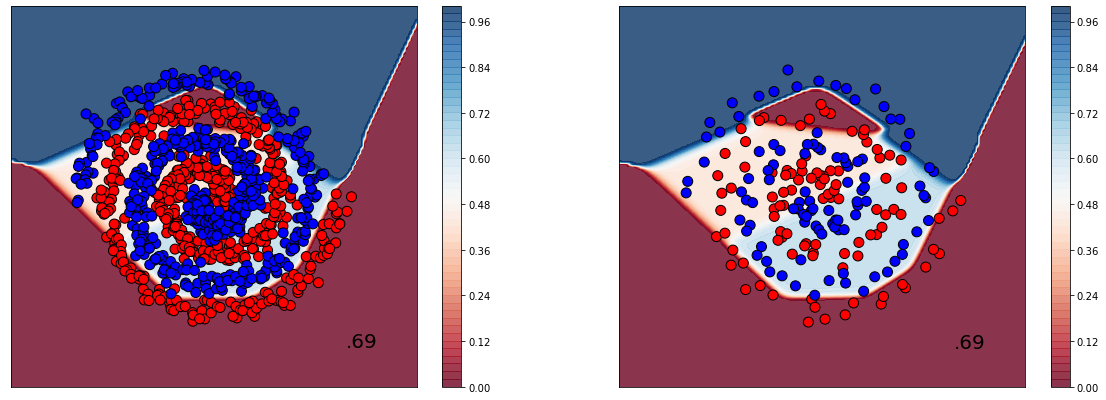

In [84]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
score_nf_train = model_no_feat.evaluate(X, y, verbose=0)[1]
score_nf_test = model_no_feat.evaluate(X_test, y_test, verbose=0)[1]
plot_boundaries_keras(X, y, score_nf_train, probability_func=model_no_feat.predict, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_nf_test, probability_func=model_no_feat.predict, ax=ax2)

##### 
##### 
##### 
#### Multitask model, 1 input, 1 dense, 3 outputs

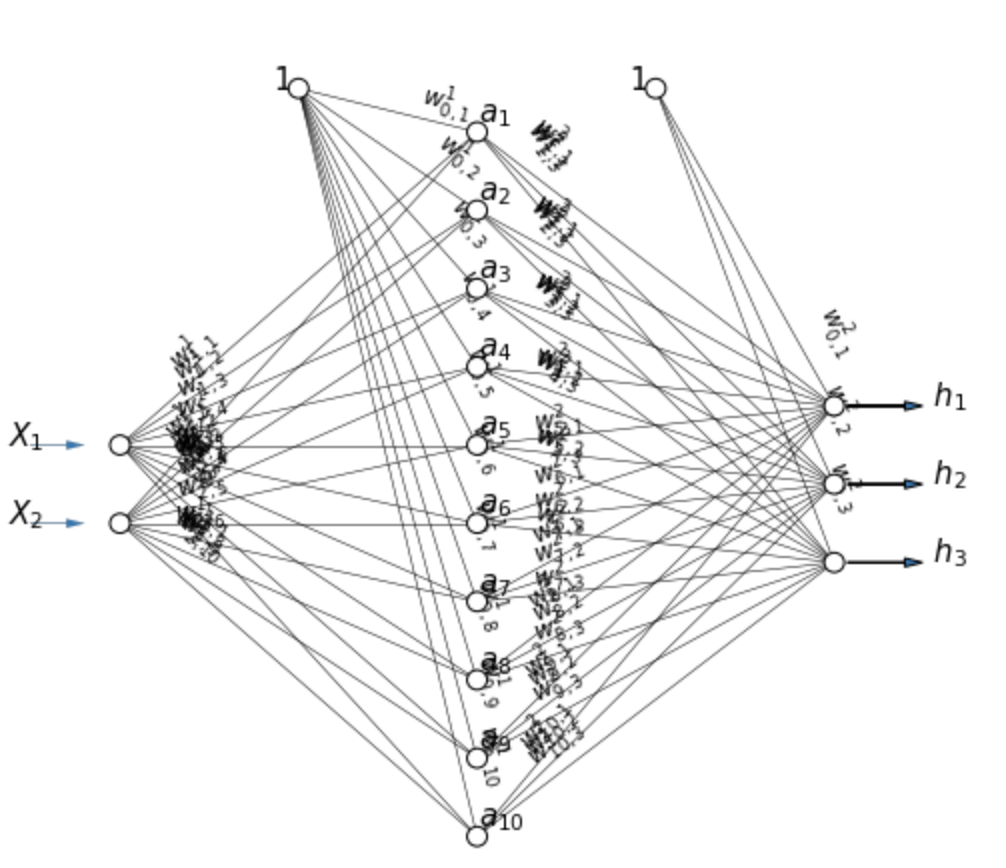

In [87]:
def get_two_out_model(activation='sigmoid', input_dim=2, hidden_units=[10], lr=0.01, compile_model=True):
    
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units[0], activation=activation, name=f'hidden_1')(X_in)
    for i, units in enumerate(hidden_units[1:]): # This for allows to add more layers, e.g. hidden_units=[10,20]
        X = Dense(units, activation=activation, name=f'hidden_{i+2}')(X)
    cat_out = Dense(1, name='Categorical_out', activation='sigmoid')(X) # 1st output, categorical
    radius = Dense(1, name='Linear_out_radius', activation='sigmoid')(X) # 2nd output, radius
    theta = Dense(1, name='Linear_out_theta', activation='linear')(X) # 3rd output, theta
    
    model = Model(X_in, [cat_out, radius, theta]) # 1 input, 3 outpus (different losses and metrics depending on each output)
    if compile_model:
        losses = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': 'binary_crossentropy'}
        metrics = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': ['accuracy', 'mse', 'binary_crossentropy']}
        loss_weights = {'Linear_out_radius': 1,'Linear_out_theta': 1, 'Categorical_out': 1} # Weighted percentages to calculate general loss, we can weight one loss more than the others if needed
        model.compile(Adam(learning_rate=lr), loss=losses, metrics=metrics, loss_weights=loss_weights)
    return model

In [88]:
model = get_two_out_model(activation='sigmoid', hidden_units=[100], lr = 0.1)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          300         Input[0][0]                      
__________________________________________________________________________________________________
Categorical_out (Dense)         (None, 1)            101         hidden_1[0][0]                   
__________________________________________________________________________________________________
Linear_out_radius (Dense)       (None, 1)            101         hidden_1[0][0]                   
____________________________________________________________________________________________

In [89]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [90]:
time.perf_counter()

529881.065152142

In [91]:
model.fit(X, [y, X_sphere[:, 0], X_sphere[:, 1]], verbose=0, 
          epochs=2000, batch_size=100, 
          validation_data=(X_test, [y_test, X_sphere_test[:, 0], X_sphere_test[:, 1]]))

In [92]:
model.history.history.keys()

dict_keys(['loss', 'Categorical_out_loss', 'Linear_out_radius_loss', 'Linear_out_theta_loss', 'Categorical_out_accuracy', 'Categorical_out_mse', 'Categorical_out_binary_crossentropy', 'Linear_out_radius_mse', 'Linear_out_theta_mse', 'val_loss', 'val_Categorical_out_loss', 'val_Linear_out_radius_loss', 'val_Linear_out_theta_loss', 'val_Categorical_out_accuracy', 'val_Categorical_out_mse', 'val_Categorical_out_binary_crossentropy', 'val_Linear_out_radius_mse', 'val_Linear_out_theta_mse'])

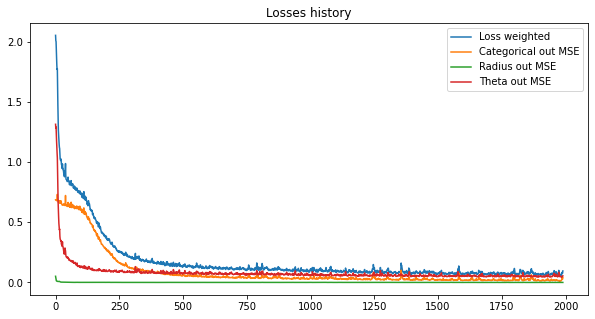

In [93]:
plt.figure(figsize=(10,5))
fr = 10
plt.plot(model.history.history['loss'][fr:], label='Loss weighted') # Summing all losses (weighted)
plt.plot(model.history.history['Categorical_out_loss'][fr:], label='Categorical out MSE')
plt.plot(model.history.history['Linear_out_radius_loss'][fr:], label='Radius out MSE')
plt.plot(model.history.history['Linear_out_theta_loss'][fr:], label='Theta out MSE')
plt.title('Losses history')
plt.legend()

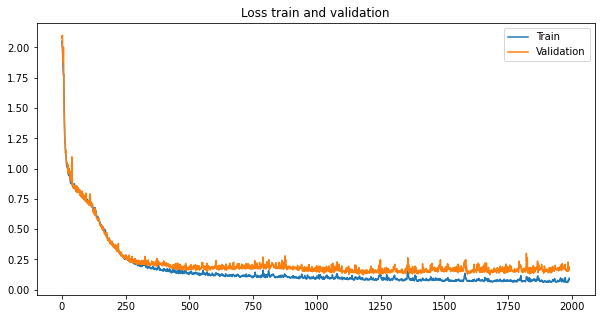

In [97]:
plt.figure(figsize=(10,5))
fr = 10
plt.plot(model.history.history['loss'][fr:], label='Train')
plt.plot(model.history.history['val_loss'][fr:], label='Validation')
plt.title('Loss train and validation')
plt.legend()

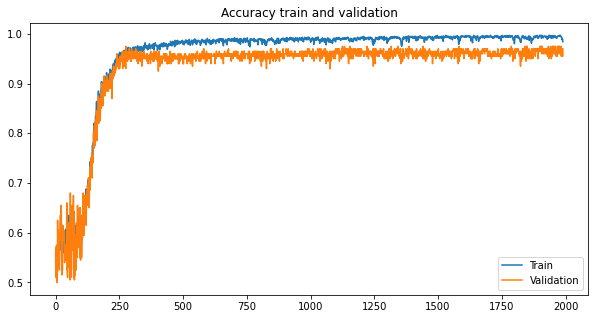

In [98]:
plt.figure(figsize=(10,5))
fr = 10
plt.plot(model.history.history['Categorical_out_accuracy'][fr:], label='Train')
plt.plot(model.history.history['val_Categorical_out_accuracy'][fr:], label='Validation')
plt.title('Accuracy train and validation')
plt.legend()

In [65]:
print(model.metrics_names)
model.evaluate(X, [y, X_sphere[:, 0], X_sphere[:, 1]], verbose=0)

['loss', 'Categorical_out_loss', 'Linear_out_radius_loss', 'Linear_out_theta_loss', 'Categorical_out_accuracy', 'Categorical_out_mse', 'Categorical_out_binary_crossentropy', 'Linear_out_radius_mse', 'Linear_out_theta_mse']


[0.057726386934518814,
 0.016428863629698753,
 0.0005899029201827943,
 0.040707625448703766,
 0.9940000176429749,
 0.004049613140523434,
 0.016428863629698753,
 0.0005899029201827943,
 0.040707625448703766]

In [66]:
def predict_proba(X):
    return model.predict(X)[0]

def score_func(X, y):
    return model.evaluate(X, y, verbose=0)[4]

In [67]:
score_mt_train = score_func(X, [y, X_sphere[:, 0], X_sphere[:, 1]])
score_mt_test = score_func(X_test, [y_test, X_sphere_test[:, 0], X_sphere_test[:, 1]])

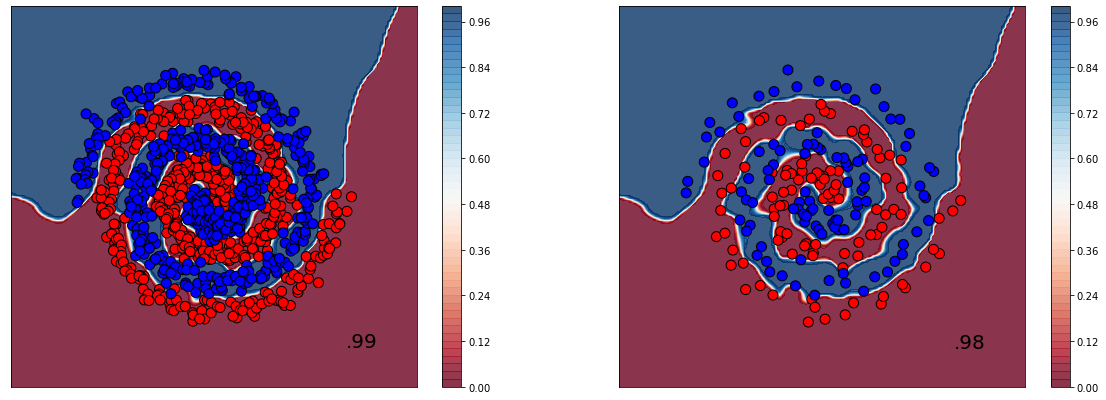

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
plot_boundaries_keras(X, y, score_mt_train, probability_func=predict_proba, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_mt_test, probability_func=predict_proba, ax=ax2)

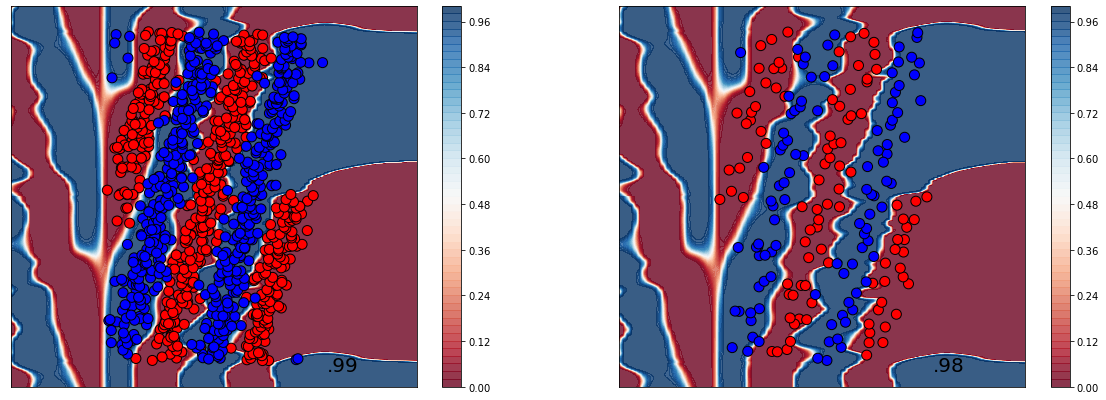

In [71]:
def predict_proba_inv(X_sphere):
    X_cart = get_cart_coordinates(X_sphere)
    return model.predict(X_cart)[0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
plot_boundaries_keras(X_sphere, y, score_mt_train, probability_func=predict_proba_inv, ax=ax1)
plot_boundaries_keras(X_sphere_test, y_test, score_mt_test, probability_func=predict_proba_inv, ax=ax2)

In [ ]:
# End